# SWIFTGalaxy quick start guide for Colibre on cosma

First some notes on package versions:
 - Thanks to Josh Borrow for putting up with my pestering and fixing bugs at the last minute. Also to Rob McGibbon for work on SOAP support in `swiftsimio`.
 - There's been lots of active development very recently, packages haven't made it to PyPI just yet, so need to install from github (for now).
 - Doing `pip install git+https://github.com/SWIFTSIM/swiftgalaxy.git` should install `swiftgalaxy` with SOAP support and its dependencies with compatible versions. The first version with SOAP support is labeled `1.1.0`.
 - The required version of `swiftsimio` (at least `9.0.1`) can be installed directly with `pip install git+https://github.com/SWIFTSIM/swiftsimio.git`.
You can check your `swiftsimio` and `swiftgalaxy` versions with the next cell. If it produces import errors you probably have incompatible package versions for `swiftsimio`, `swiftgalaxy` and/or others.
 - This tutorial also uses `matplotlib` that's not a required dependency of the packages above (so `pip install matplotlib` if not already done).

In [1]:
import swiftgalaxy
import swiftsimio
from packaging.version import Version

assert Version(swiftsimio.__version__) >= Version("9.0.1")
assert Version(swiftgalaxy.__version__) >= Version("1.1.0")

We'll use this SOAP catalogue in this example:

In [2]:
import os

colibre_base_path = "/cosma8/data/dp004/colibre/Runs/"
simulation_dir = "L0050N0376/Fiducial_test"
soap_catalogue_file = os.path.join(
    colibre_base_path,
    simulation_dir,
    "SOAP/halo_properties_0127.hdf5",
)

SOAP records which particles belong to each individual halo in a set of "membership" files, usually found alongside the halo catalogue in a subdirectory, in this case `membership_0123/membership_0123.X.hdf5` (where X is replaced by integers, each corresponding to one part of the "raw" snapshot). `swiftgalaxy` expects to find the information contained in these files directly in the (single, monolithic) simulation snapshot file. Such a snapshot file:
 - Exists alongside the SOAP catalogue as `colibre_with_SOAP_membership_0123.hdf5`.
 - It is planned that a copy be placed in the same directory as the snapshots, but at the time of writing this has not happened yet.

In [3]:
virtual_snapshot_file = os.path.join(
    colibre_base_path, simulation_dir, "SOAP/colibre_with_SOAP_membership_0127.hdf5"
)

In the coming weeks files like this will become available alongside the snapshots, this notebook will be updated accordingly.

We can load the entire SOAP catalogue using `swiftsimio` to browse for an interesting galaxy to look at. To avoid having too many particles let's pick something with an m200c of about 1e11 Msun. We'll just grab the first eligible galaxy in the list:

In [4]:
import numpy as np
import unyt as u  # package used by swiftsimio to provide physical units
from swiftsimio import SWIFTDataset

sd = SWIFTDataset(soap_catalogue_file)
m200c = sd.spherical_overdensity_200_crit.total_mass
candidates = np.argwhere(
    np.logical_and(m200c > 1e11 * u.Msun, m200c < 2e11 * u.Msun)
).squeeze()
chosen_halo_index = candidates[0]
print(chosen_halo_index)

574


/cosma/home/durham/dc-oman1/.virtualenv/sgdemo/lib/python3.12/site-packages/swiftsimio/objects.py:273: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


The warning is complaining that `1e11 * u.Msun` doesn't include information about whether and how the quantity depends on the scale factor (while `m200c` does). The mass doesn't depend on the scale factor (and we're at `a=1` anyway) so we can safely ignore it.

Now we can create a `SWIFTGalaxy` to experiment with. The `halo_index` selects one row from the halo catalogue. The `SWIFTGalaxy` object will contain all of the integrated properties of this object from the halo catalogue and also let us access its particles from the snapshot file.

In [5]:
import unyt as u  # package used by swiftsimio to provide physical units on arrays
from swiftgalaxy import SWIFTGalaxy, SOAP

sg = SWIFTGalaxy(
    virtual_snapshot_file,
    SOAP(
        soap_catalogue_file,
        halo_index=chosen_halo_index,
    ),
)

We can define a function that uses some of `swiftsimio`'s visualisation tools to make some quick images of this galaxy:

In [6]:
from swiftsimio import SWIFTDataset
from swiftsimio.visualisation.projection import project_gas, project_pixel_grid
from swiftsimio.visualisation import (
    generate_smoothing_lengths,
)  # if not found try `from swiftsimio.visualisation import generate_smoothing_lengths`
import matplotlib.pyplot as plt
import matplotlib.colors


def myvis(sg, disc_radius=15 * u.kpc, halo_radius=200 * u.kpc, fignum=1):
    disc_region = [-disc_radius, disc_radius, -disc_radius, disc_radius]
    halo_region = [-halo_radius, halo_radius, -halo_radius, halo_radius]
    gas_map = project_gas(
        sg,
        resolution=256,
        project="masses",
        parallel=True,
        region=disc_region,
    )
    dm_map = project_pixel_grid(
        data=sg.dark_matter,
        boxsize=sg.metadata.boxsize,
        resolution=256,
        project="masses",
        parallel=True,
        region=halo_region,
    )
    star_map = project_pixel_grid(
        data=sg.stars,
        boxsize=sg.metadata.boxsize,
        resolution=256,
        project="masses",
        parallel=True,
        region=disc_region,
    )

    fig = plt.figure(fignum, figsize=(10, 3))
    sp1, sp2, sp3 = [fig.add_subplot(1, 3, i) for i in range(1, 4)]
    sp1.imshow(
        matplotlib.colors.LogNorm()(gas_map.value), cmap="viridis", extent=disc_region
    )
    sp1.set_xlabel(f"x' [{disc_radius.units}]")
    sp1.set_ylabel(f"y' [{disc_radius.units}]")
    sp1.text(
        0.9, 0.9, "gas", color="white", ha="right", va="top", transform=sp1.transAxes
    )
    sp2.imshow(
        matplotlib.colors.LogNorm()(dm_map),
        cmap="inferno",
        extent=halo_region,
    )
    sp2.plot(
        [-disc_radius, -disc_radius, disc_radius, disc_radius, -disc_radius],
        [-disc_radius, disc_radius, disc_radius, -disc_radius, -disc_radius],
        "-k",
    )
    sp2.set_xlabel(f"x' [{halo_radius.units}]")
    sp2.set_ylabel(f"y' [{halo_radius.units}]")
    sp2.text(
        0.9, 0.9, "DM", ha="right", va="top", color="white", transform=sp2.transAxes
    )
    sp3.imshow(
        matplotlib.colors.LogNorm()(star_map),
        cmap="magma",
        extent=disc_region,
    )
    sp3.set_xlabel(f"x' [{disc_radius.units}]")
    sp3.set_ylabel(f"y' [{disc_radius.units}]")
    sp3.text(0.9, 0.9, "stars", ha="right", va="top", transform=sp3.transAxes)
    fig.subplots_adjust(wspace=0.4)

Before visualising the galaxy, we need to initialise some smoothing lengths for the particles (this bit of code is taken from the `swiftsimio` visualisation documentation). If you get an error similar to `IndexError: index -1 is out of bounds for axis 0 with size 0`, you have probably chosen a galaxy with zero particles of at least one type (dark matter, stars or gas).

In [7]:
for ptype in "gas", "dark_matter", "stars":
    getattr(sg, ptype).smoothing_length = generate_smoothing_lengths(
        getattr(sg, ptype).coordinates + sg.centre,
        sg.metadata.boxsize,
        kernel_gamma=1.8,
        neighbours=57,
        speedup_fac=2,
        dimension=3,
    )

Let's have a first look at our galaxy:

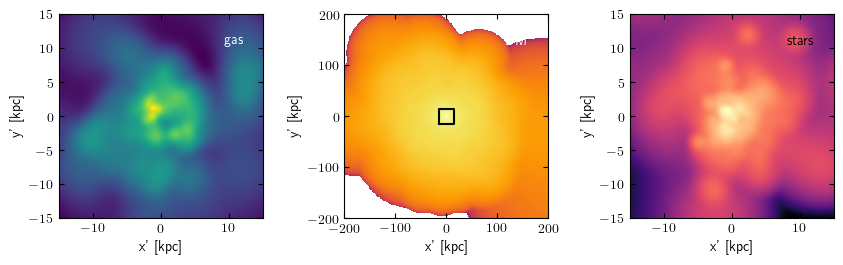

In [8]:
myvis(sg)

## Quick overview of `swiftgalaxy` features

### `SWIFTDataset` features

`SWIFTGalaxy` is built upon `swiftsimio` and takes advantage of all the features of the `SWIFTDataset` class, notably "lazy loading" of particle data. A `SWIFTGalaxy` inherits from the `SWIFTDataset` class, and should therefore in principle be accepted by functions expecting a `SWIFTDataset` (in practice there still some work to do on this front, e.g. some adjustments needed for some functions from the `swiftsimio.visualisation` module).

### SOAP integrated properties

A `swiftsimio` interface to the SOAP halo catalogue is exposed through the `halo_catalogue` attribute of our `SWIFTGalaxy`, and only the properties of the particular galaxy of interest are loaded. This makes accessing integrated properties particularly convenient, for instance we can grab M200crit:

In [9]:
sg.halo_catalogue.spherical_overdensity_200_crit.total_mass.to(u.Msun)

cosmo_array([1.0595374e+11], dtype=float32, units='1.98841586e+30*kg', comoving=False)

Due to the current working of `swiftsimio` this any property accessed in this way always has an extra dimension (so something that you might expect to be a scalar is an array with dimension `(1,)`, a 3-element array would arrive as a `(1,3)` array, etc.). You may wish to use `.squeeze()` on the result to remove any redundant dimensions. This might be incorporated into `swiftsimio` in the future.

### Automatic recentering

When the `SWIFTGalaxy` is created, the coordinates are automatically centred on the position and velocity (according to the halo finder) of the galaxy of interest. The SOAP catalogue actually contains many centres and velocities defined in different ways for each halo; which one to use is configurable. The automatic recentering can also be disabled entirely, or the centre of another `SWIFTGalaxy` can be used (can be useful e.g. for putting a satellite in the coordinate frame of its central).

### Rotation & other coordinate transformations

The particles in a `SWIFTGalaxy` always occupy a common coordinate frame, such that e.g. all particles rotate together. Rotations, translations (in position) and boosts (translations in velocity) are all supported. As an example, we can rotate our galaxy. To specify a rotation, the [`scipy.spatial.transform.Rotation`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.from_euler.html) class is used. This has options to accept rotation matrices, Euler angles, and more. The SOAP catalogue helpfully has pre-computed angular momentum vectors for particles of different types selected in different apertures. Let's use one of these to define a rotation matrix and rotate the stars to a face-on view.

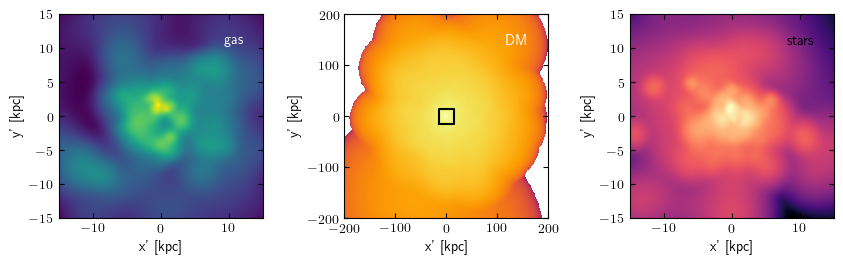

In [10]:
from scipy.spatial.transform import Rotation

Lstars = sg.halo_catalogue.exclusive_sphere_10kpc.angular_momentum_stars.squeeze()
zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
    u.dimensionless
)  # we'll align L with the z-axis
arb = np.ones(3) / np.sqrt(
    3
)  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
xvec = arb - arb.dot(zhat) * zhat
xhat = xvec / np.sum(xvec**2)
yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
rotmat = np.vstack((xhat, yhat, zhat))
sg.rotate(Rotation.from_matrix(rotmat))
myvis(sg)

### Additional coordinates

When working with a galaxy it is often convenient to work in spherical or cylindircal coordinates. These are built into a `SWIFTGalaxy` and are evaluated lazily as and when needed. Their consistency when the coordinate frame is transformed is also ensured. As an illustrative example, we can plot the azimuthal velocity against the radial velocity - the parameters in which the Gaia-Enceladus (or "sausage") structure in the Milky Way was identified. This quick look won't reveal anything quite so profound but illustrates how easy it is to use non-cartesian coordinates.

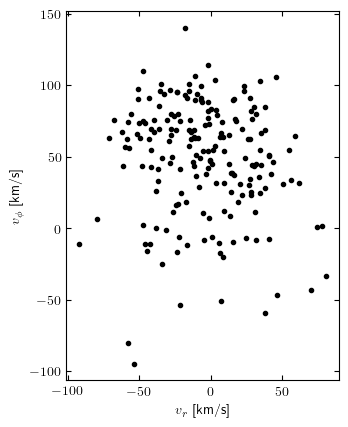

In [11]:
plt.plot(
    sg.stars.spherical_velocities.r.to_value(u.km / u.s),
    sg.stars.spherical_velocities.phi.to_value(u.km / u.s),
    ".k",
    rasterized=True,
)
plt.xlabel(r"$v_r$ [km/s]")
plt.ylabel(r"$v_\phi$ [km/s]")
plt.gca().set_aspect("equal")

### Particle masking

`SWIFTGalaxy` enables selecting subsets of particles in intuitive, syntactically simply ways (beyond what's supported by `swiftsimio`, actually). As a crude example, we can chop a hole out of the centre of the stellar and gas discs. Masking on any other property (gas of a given temperature, stars of a given age, etc.) is also possible, of course.

/cosma/home/durham/dc-oman1/.virtualenv/sgdemo/lib/python3.12/site-packages/swiftsimio/objects.py:273: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor ((a**2.0)**0.5 at a=0.9999999999999997) for all arguments.
  warnings.warn(


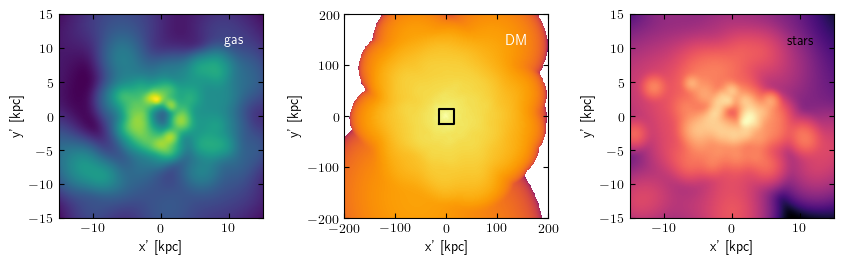

In [12]:
from swiftgalaxy import MaskCollection

sg.mask_particles(
    MaskCollection(
        gas=sg.gas.cylindrical_coordinates.R > 2 * u.kpc,
        stars=sg.stars.cylindrical_coordinates.R > 2 * u.kpc,
    )
)
myvis(sg)

The mask applies to all particle properties, e.g. if we next loaded the gas temperatures they would be masked to match. It's also possible to obtain masked particle datasets with `sg.gas[...]` (careful, unlike using `sg.mask_particles` these are copies, so memory consumption can increase quickly), amongst other options.

### Documentation

Detailed documentation for `swiftgalaxy` including descriptions of more options and more detailed explanations of features is [hosted on readthedocs](https://swiftgalaxy.readthedocs.io/en/latest/halo_finders/index.html). Any feedback on the code or documentation is very welcome by email (kyle.a.oman@durham.ac.uk), on Slack, or through an issue on the SWIFTGalaxy [github repository](https://github.com/SWIFTSIM/swiftgalaxy).

## New feature: efficient iteration over galaxies

The `SWIFTGalaxy` demonstrated above offers a nice interface, but if looking at many galaxies using it adds substantial overhead (mostly duplicated i/o if any of the galaxies are spatially close together). I've implemented a class that enables efficient iteration over `SWIFTGalaxy` objects. The core functionality works well on Colibre data. I still need to tidy up the user interface aspects a bit, and add documentation, automated testing and support for other halo finders, but if this feature is useful to you now and you're feeling a bit adventurous you can start trying it out with the caveat that things could still change a bit. 
- First you need to switch your `swiftgalaxy` installation to the development branch: `pip install git+https://github.com/SWIFTSIM/swiftgalaxy.git@iterator` (might need to `pip uninstall swiftgalaxy` first).
- Remember to restart the kernel for this notebook after changing packages.

There's a so far undiagnosed bug affecting the 12 Mpc Colibre test box, so we're going to switch to the 50 Mpc box. Let's again grab a list of candidate objects with `m200c > 2e11 * u.Msun`, but trim it to the first 5 for this demo (there are a lot of them in this larger volume).

In [16]:
simulation_dir = "L0050N0376/Fiducial_test"
soap_catalogue_file = os.path.join(
    colibre_base_path,
    simulation_dir,
    "SOAP/halo_properties_0127.hdf5",
)
virtual_snapshot_file = os.path.join(
    colibre_base_path, simulation_dir, "SOAP/colibre_with_SOAP_membership_0127.hdf5"
)
sd = SWIFTDataset(soap_catalogue_file)
m200c = sd.spherical_overdensity_200_crit.total_mass
candidates = np.argwhere(
    np.logical_and(m200c > 1e11 * u.Msun, m200c < 2e11 * u.Msun)
).squeeze()
candidates = candidates[:5]
print(candidates)

[ 574 1388 2917 2923 4279]


/cosma/home/durham/dc-oman1/.virtualenv/sgdemo/lib/python3.12/site-packages/swiftsimio/objects.py:273: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (1 at a=0.9999999999999997) for all arguments.
  warnings.warn(


We can use the `SWIFTGalaxies` (not `SWIFTGalaxy`) class to help us iterate over these. This class offers most of the same options as the `SWIFTGalaxy` class, but expects a `SOAP` object with a list of targets passed to `halo_index` instead of a single integer. The `SWIFTGalaxies` will figure out an efficient iteration strategy to minimize I/O.

Unfortunately the class cannot guess what data you will want to use in the future, so to work efficiently it needs to know what fields it will need to make available in the future (so that they can be read in once in advance for all galaxies in a common region). These are specified with the `preload` argument.

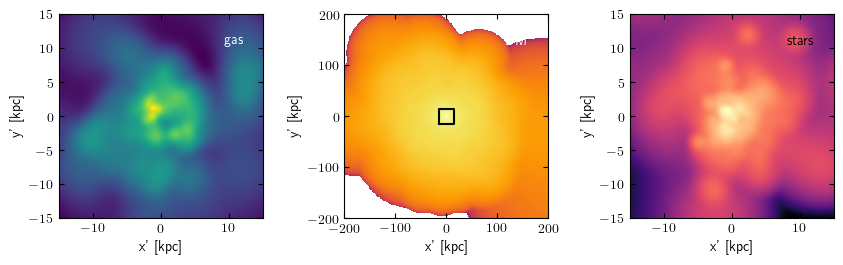

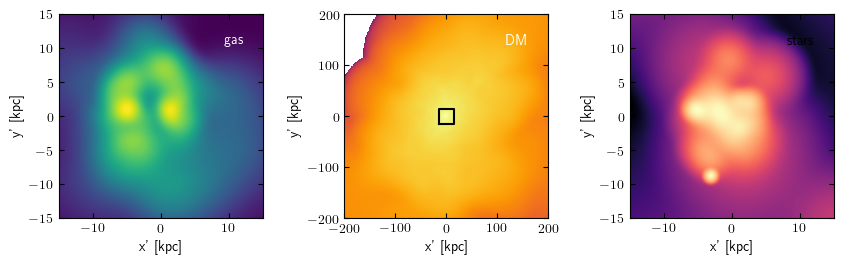

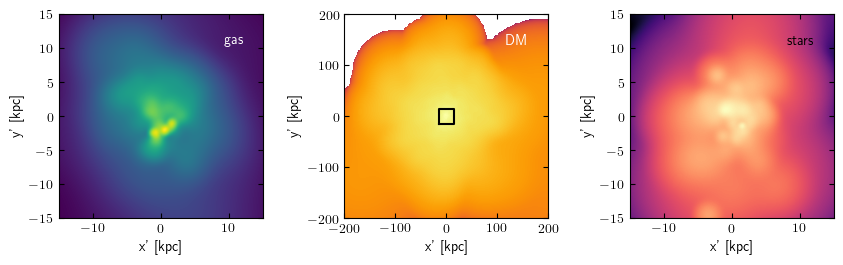

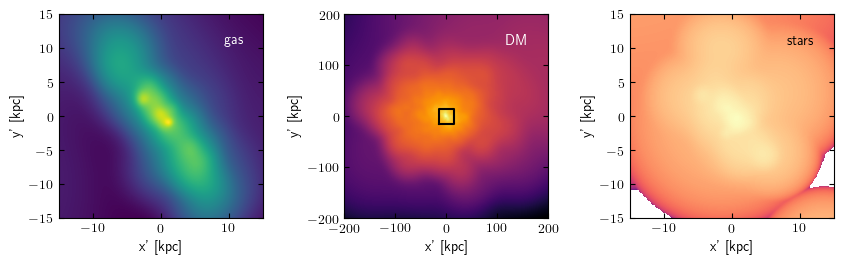

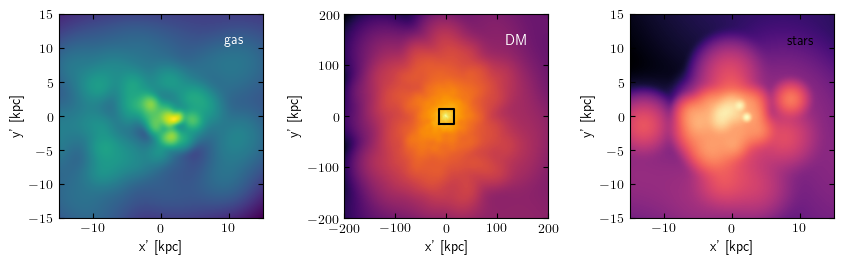

In [17]:
from swiftgalaxy.iterator import SWIFTGalaxies

figcounter = 2
for sg in SWIFTGalaxies(
    virtual_snapshot_file,
    SOAP(
        soap_catalogue_file,
        halo_index=candidates[:5],
    ),
    preload=(
        "gas.coordinates",
        "gas.masses",
        "dark_matter.coordinates",
        "dark_matter.masses",
        "stars.coordinates",
        "stars.masses",
    ),
):
    for ptype in "gas", "dark_matter", "stars":
        try:
            getattr(sg, ptype).smoothing_length = generate_smoothing_lengths(
                getattr(sg, ptype).coordinates + sg.centre,
                sg.metadata.boxsize,
                kernel_gamma=1.8,
                neighbours=57,
                speedup_fac=2,
                dimension=3,
            )
        except IndexError:
            # no particles of this type?                                                          
            print(f"no {ptype}")
    myvis(sg, fignum=figcounter)
    figcounter += 1
